Initializing NUTS using jitter+adapt_diag...


=== 単純比較（Naive Difference） ===
X=1（施策あり）の平均購買率: 0.1340
X=0（施策なし）の平均購買率: 0.2693
単純な差 (mean_1 - mean_0): -0.1353
95%信頼区間: [-0.1636, -0.1070]



Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, beta_X, beta_F, beta_R, beta_E, beta_A, beta_C, beta_D]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 7 seconds.


=== 総合効果モデルの係数サマリー ===
            mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
intercept -2.829  0.157  -3.137   -2.547      0.002    0.002    5064.0   
beta_X     0.773  0.133   0.530    1.030      0.002    0.001    5831.0   
beta_F     0.932  0.062   0.818    1.051      0.001    0.001    6280.0   
beta_R    -1.039  0.080  -1.187   -0.886      0.001    0.001    7192.0   
beta_E     0.926  0.060   0.817    1.039      0.001    0.001    6421.0   
beta_A     0.151  0.047   0.066    0.241      0.001    0.001    8767.0   
beta_C     0.263  0.066   0.139    0.389      0.001    0.001    9215.0   
beta_D     0.121  0.106  -0.078    0.316      0.001    0.001    8249.0   

           ess_tail  r_hat  
intercept    5088.0    1.0  
beta_X       5619.0    1.0  
beta_F       5554.0    1.0  
beta_R       6067.0    1.0  
beta_E       6029.0    1.0  
beta_A       5682.0    1.0  
beta_C       5715.0    1.0  
beta_D       5589.0    1.0  

=== ベイズ回帰による平均因果効果 (ATE: 総合効果) ===
ATE の平均: 0.09

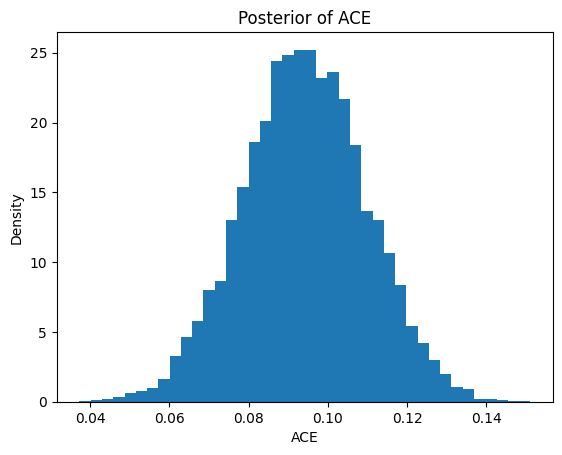

In [ ]:
# ============================================
#  6-2 マーケティング施策評価
#  ・単純比較では効果が見えない
#  ・交絡調整すると正の効果が出る
# ============================================

import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

RANDOM_SEED = 123
rng = np.random.default_rng(RANDOM_SEED)

# -----------------------------
# 1. データ生成：
# -----------------------------

def simulate_marketing_data(n=3000, rng=None):
    """
    マーケティング施策（クーポンメール）の疑似データを生成する。
    変数:
      Y : 購買フラグ (0/1)
      X : 施策配信 (0/1)
      Z : クリック / キャンペーン訪問 (0/1) 
      F : 過去購入回数
      R : Recency（日数）
      E : 過去メール開封率 (0〜1)
      A : 年代カテゴリ (0〜3)
      C : 嗜好カテゴリ (0〜2)
      D : デバイス (0=PC,1=スマホ)

    設計方針:
      - 真の施策効果は「正」（メールは効いている）
      - ただし X は「買いにくい顧客」に偏って配られる → 単純比較だと効果が見えない
    """
    if rng is None:
        rng = np.random.default_rng()

    # --- 顧客属性・履歴の生成 ---

    # 購入頻度 F (0〜10)
    F = rng.poisson(lam=2.5, size=n)
    F = np.clip(F, 0, 10)

    # Recency R（最終購入からの日数）
    R = rng.exponential(scale=90.0, size=n)
    R = np.clip(R, 0, 365)

    # 過去メール開封率 E (0〜1)
    E = rng.beta(a=1.5, b=3.0, size=n)

    # 年代 A: 0=20代,1=30代,2=40代,3=50代+
    A = rng.integers(0, 4, size=n)

    # 嗜好 C: 0=スキンケア,1=メイク,2=ヘアケア など
    C = rng.integers(0, 3, size=n)

    # デバイス D: 0=PC, 1=スマホ
    D = rng.integers(0, 2, size=n)

    # 標準化
    F_std = (F - F.mean()) / F.std()
    R_std = (R - R.mean()) / R.std()
    E_std = (E - E.mean()) / E.std()

    # --- 施策配信 X の割当メカニズム ---
    # 「買いにくい人に施策を打つ」ようなバイアスを入れる
    # logit(Pr(X=1)) = α0 + αF*F_std + αR*R_std + αE*E_std
    alpha0 = 0.0
    alpha_F = -1.2   # 頻度が低いほど X=1 に
    alpha_R = 1.0    # 長く買ってないほど X=1 に
    alpha_E = -1.0   # 開封率が低いほど X=1 に

    lin_X = alpha0 + alpha_F * F_std + alpha_R * R_std + alpha_E * E_std
    prob_X = 1 / (1 + np.exp(-lin_X))
    X = rng.binomial(1, prob_X, size=n)

    # --- メディエータ Z（クリック / 訪問）の生成 ---
    # logit(Pr(Z=1)) = β0 + βX*X + βF*F_std + βR*R_std + βE*E_std
    beta0 = -2.0
    beta_X = 2.0    # メール受信者はクリックしやすい
    beta_F = 0.3    # 頻度高い人はクリックしやすい
    beta_R = -0.5   # 最近買っている人ほどクリックしやすい
    beta_E = 1.2    # 開封率高い人はクリックしやすい

    lin_Z = (beta0
             + beta_X * X
             + beta_F * F_std
             + beta_R * R_std
             + beta_E * E_std)
    p_Z = 1 / (1 + np.exp(-lin_Z))
    Z = rng.binomial(1, p_Z, size=n)

    # --- アウトカム Y（購買）の生成 ---
    # logit(Pr(Y=1)) = γ0 + γX*X + γZ*Z + γF*F_std + γR*R_std + γE*E_std
    #                  + γA*A + γC*C + γD*D
    gamma0 = -3.0
    gamma_X = 0.4    # 直接効果（メールを見たこと自体の効果）
    gamma_Z = 1.2    # クリック / ページ訪問の効果（媒介経路）
    gamma_F = 0.9
    gamma_R = -1.0
    gamma_E = 0.7
    gamma_A = 0.1
    gamma_C = 0.2
    gamma_D = 0.2

    lin_p = (gamma0
             + gamma_X * X
             + gamma_Z * Z
             + gamma_F * F_std
             + gamma_R * R_std
             + gamma_E * E_std
             + gamma_A * A
             + gamma_C * C
             + gamma_D * D)

    p = 1 / (1 + np.exp(-lin_p))
    Y = rng.binomial(1, p, size=n)

    df = pd.DataFrame({
        "Y": Y,
        "X": X,
        "Z": Z,
        "F": F,
        "R": R,
        "E": E,
        "A": A,
        "C": C,
        "D": D,
        "p_true": p,
        "prob_X": prob_X,
        "p_Z_true": p_Z,
    })

    return df

# -----------------------------
# 2. 単純比較（X だけで Y を比較）
# -----------------------------

def estimate_naive_difference_binary(df):
    """
    購買フラグ Y (0/1) に対して、
    X=1 vs X=0 の単純な平均差を推定する。
    """
    grp = df.groupby("X")["Y"]
    mean_0 = grp.mean().loc[0]
    mean_1 = grp.mean().loc[1]
    var_0 = grp.var(ddof=1).loc[0]
    var_1 = grp.var(ddof=1).loc[1]
    n_0 = grp.size().loc[0]
    n_1 = grp.size().loc[1]

    diff = mean_1 - mean_0

    se = np.sqrt(var_1 / n_1 + var_0 / n_0)
    z = 1.96
    ci_low = diff - z * se
    ci_high = diff + z * se

    return diff, mean_1, mean_0, ci_low, ci_high

# -----------------------------
# 3. ベイズロジスティック回帰
# -----------------------------

def fit_bayesian_logistic_total_effect(df, draws=2000, tune=1000, random_seed=RANDOM_SEED):
    """
    総合効果（X の ACE）を見るためのモデル（Z を入れない）:
      Y ~ Bernoulli(p)
      logit(p) = β0 + βX*X + βF*F_std + βR*R_std + βE*E_std + βA*A + βC*C + βD*D
    """
    Y = df["Y"].values
    X = df["X"].values
    F = df["F"].values
    R = df["R"].values
    E = df["E"].values
    A = df["A"].values
    C = df["C"].values
    D = df["D"].values

    F_std = (F - F.mean()) / F.std()
    R_std = (R - R.mean()) / R.std()
    E_std = (E - E.mean()) / E.std()

    with pm.Model() as model:
        intercept = pm.Normal("intercept", mu=0.0, sigma=5.0)
        beta_X = pm.Normal("beta_X", mu=0.0, sigma=5.0)

        beta_F = pm.Normal("beta_F", mu=0.0, sigma=5.0)
        beta_R = pm.Normal("beta_R", mu=0.0, sigma=5.0)
        beta_E = pm.Normal("beta_E", mu=0.0, sigma=5.0)
        beta_A = pm.Normal("beta_A", mu=0.0, sigma=5.0)
        beta_C = pm.Normal("beta_C", mu=0.0, sigma=5.0)
        beta_D = pm.Normal("beta_D", mu=0.0, sigma=5.0)

        eta = (intercept
               + beta_X * X
               + beta_F * F_std
               + beta_R * R_std
               + beta_E * E_std
               + beta_A * A
               + beta_C * C
               + beta_D * D)

        p = pm.math.sigmoid(eta)

        pm.Bernoulli("y_obs", p=p, observed=Y)

        trace = pm.sample(
            draws=draws,
            tune=tune,
            chains=4,
            target_accept=0.9,
            random_seed=random_seed
        )

    return model, trace

# -----------------------------
# 4. ACE（総合効果）の計算
# -----------------------------

def compute_ace_from_trace_marketing(df, trace):
    """
    総合効果モデルの事後サンプルから、
    do(X=1) と do(X=0) の購買確率差（ATE）を計算する。
    """
    F = df["F"].values
    R = df["R"].values
    E = df["E"].values
    A = df["A"].values
    C = df["C"].values
    D = df["D"].values

    F_std = (F - F.mean()) / F.std()
    R_std = (R - R.mean()) / R.std()
    E_std = (E - E.mean()) / E.std()

    post = trace.posterior
    intercept = post["intercept"].values
    beta_X = post["beta_X"].values
    beta_F = post["beta_F"].values
    beta_R = post["beta_R"].values
    beta_E = post["beta_E"].values
    beta_A = post["beta_A"].values
    beta_C = post["beta_C"].values
    beta_D = post["beta_D"].values

    n_chain, n_draw = intercept.shape
    n_samples = n_chain * n_draw

    intercept = intercept.reshape(n_samples, 1)
    beta_X = beta_X.reshape(n_samples, 1)
    beta_F = beta_F.reshape(n_samples, 1)
    beta_R = beta_R.reshape(n_samples, 1)
    beta_E = beta_E.reshape(n_samples, 1)
    beta_A = beta_A.reshape(n_samples, 1)
    beta_C = beta_C.reshape(n_samples, 1)
    beta_D = beta_D.reshape(n_samples, 1)

    F_row = F_std.reshape(1, -1)
    R_row = R_std.reshape(1, -1)
    E_row = E_std.reshape(1, -1)
    A_row = A.reshape(1, -1)
    C_row = C.reshape(1, -1)
    D_row = D.reshape(1, -1)

    # do(X=1)
    X1_row = np.ones_like(F_row)
    eta1 = (intercept
            + beta_X * X1_row
            + beta_F * F_row
            + beta_R * R_row
            + beta_E * E_row
            + beta_A * A_row
            + beta_C * C_row
            + beta_D * D_row)
    p1 = 1 / (1 + np.exp(-eta1))

    # do(X=0)
    X0_row = np.zeros_like(F_row)
    eta0 = (intercept
            + beta_X * X0_row
            + beta_F * F_row
            + beta_R * R_row
            + beta_E * E_row
            + beta_A * A_row
            + beta_C * C_row
            + beta_D * D_row)
    p0 = 1 / (1 + np.exp(-eta0))

    ate_samples = (p1 - p0).mean(axis=1)

    return ate_samples

# -----------------------------
# 6. 実行例
# -----------------------------

if __name__ == "__main__":
    rng = np.random.default_rng(RANDOM_SEED)

    # 1) データ生成（Z 付き）
    df = simulate_marketing_data(n=3000, rng=rng)

    # 2) 単純比較
    diff, mean_1, mean_0, ci_low, ci_high = estimate_naive_difference_binary(df)
    print("=== 単純比較（Naive Difference） ===")
    print(f"X=1（施策あり）の平均購買率: {mean_1:.4f}")
    print(f"X=0（施策なし）の平均購買率: {mean_0:.4f}")
    print(f"単純な差 (mean_1 - mean_0): {diff:.4f}")
    print(f"95%信頼区間: [{ci_low:.4f}, {ci_high:.4f}]")
    print()

    # 3) ベイズ回帰：総合効果
    model_total, trace_total = fit_bayesian_logistic_total_effect(df)
    print("=== 総合効果モデルの係数サマリー ===")
    print(az.summary(trace_total, var_names=[
        "intercept", "beta_X", "beta_F", "beta_R", "beta_E", "beta_A", "beta_C", "beta_D"
    ]))
    print()

    # 4) ACE の計算
    ace_samples = compute_ace_from_trace_marketing(df, trace_total)
    ace_mean = ace_samples.mean()
    ace_hdi = az.hdi(ace_samples, hdi_prob=0.95)

    print("=== ベイズ回帰による平均因果効果 (ACE: 総合効果) ===")
    print(f"ACE の平均: {ace_mean:.4f}")
    print(f"95%信用区間: [{ace_hdi[0]:.4f}, {ace_hdi[1]:.4f}]")
    print()

    # 6) ACE 事後分布の図
    plt.hist(ace_samples, bins=40, density=True)
    plt.title("Posterior of ACE")
    plt.xlabel("ACE")
    plt.ylabel("Density")
    plt.show()
